# Group 8: Image Segmentation of Lesion on Human Skin

# Coded by All: Kong Wai Kin, Adele Lim Hui Hui, Boey Hou Yan, Wai Jia Le


In [2]:
import os
import glob
import tarfile
import random
import shutil

from collections import defaultdict
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
from torchvision import tv_tensors #every do with tensor , mask/bounding box/image differentiate them, depend type of tensors, transformation

from torchinfo import summary


In [36]:
#Specify the Device, if gpu is not found then use CPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda")
else:
    print("None")

Cuda


In [5]:
#state the global variables for learnin rate, batch size, epochs, mean and standard deviation before training any models
LR = 0.001
BATCH_SIZE = 12
NUM_EPOCHS = 20
MEAN = (0.485, 0.456, 0.406)
STD  = (0.229, 0.224, 0.225)

# Data Collection
############################ 
Adapted from Practical Lab 7
############################

In [6]:
#Specify the Path for Dataset

IMAGE_PATH = "/kaggle/input/isic2018-challenge-task1-data-segmentation"
IMAGE_FILE = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input"
ANNOTATION_FILE = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth"

In [7]:
#Arrange the dataset based on their root name

root_dir   = os.path.join(IMAGE_PATH)
images_dir = os.path.join(IMAGE_FILE)
masks_dir  = os.path.join(ANNOTATION_FILE)

allmaskfiles = [os.path.splitext(os.path.basename(x))[0] for x in sorted(glob.glob(masks_dir + "/*_segmentation.png"))]
allimgfiles = [os.path.basename(x).split('.')[0] for x in sorted(glob.glob(images_dir + "/*.jpg"))]

In [8]:
#remove any images which are not 3-channel (For our dataset, all images are 3-channel image)

images_filenames = []
for image_filename in tqdm(allimgfiles, desc='Preprocessing Images'):
    image = np.array(Image.open(os.path.join(images_dir, image_filename + '.jpg')))
    if len(image.shape) == 3 and image.shape[-1] == 3: 
        images_filenames.append(image_filename)

Preprocessing Images: 100%|██████████| 2594/2594 [08:20<00:00,  5.18it/s]


In [9]:
#Distributed the Dataset training set (60%, 1550), validation set(20%, 520), testing set(20%, 524)

random.seed(42)
random.shuffle(images_filenames)

train_images_filenames = images_filenames[:1550]
val_images_filenames   = images_filenames[1550:-524]
test_images_filenames  = images_filenames[-524:]

print('Size of training set   :', len(train_images_filenames))
print('Size of validation set :', len(val_images_filenames)) #finetune and retrain it, might have overfitting, can go back
print('Size of test set       :', len(test_images_filenames)) #evaluate the test complete test accuracy, wont go back (show other)

Size of training set   : 1550
Size of validation set : 520
Size of test set       : 524


# Data Preprocessing
############################ 
Adapted from Practical Lab 7
############################

In [10]:
############################ Adapted from Practical Lab 7 ############################
#Initially the value in the masks are either 0 or 255, we convert the value of 255 to 1 in order to do the binary image segmentation task

def preprocess_mask(mask):
    if not isinstance(mask, tv_tensors.Mask):
        mask = tv_tensors.Mask(mask)
    # Convert non-zero values to 1
    mask.data[mask.data != 0] = 1
    return mask

In [11]:
############################ Reference: Practical 7 ############################

#to show one sample
def show_sample(img, mask=None, unnormalize=False):

    if isinstance(img, tv_tensors.Image):
        img = img.detach().cpu()
        if unnormalize:
            img = img*torch.tensor(STD).reshape(-1, 1, 1) + torch.tensor(MEAN).reshape(-1, 1, 1)
        img = v2.functional.to_pil_image(img)

    if mask is not None:
        if isinstance(mask, tv_tensors.Mask):
            mask = mask.detach().cpu()
            mask = v2.functional.to_pil_image(mask)

        fig, axs = plt.subplots(1, 2, figsize=(5, 3))
        axs[0].imshow(img)
        axs[0].axis('off')
        axs[0].set_title("Image")
        axs[1].imshow(mask, cmap="gray")
        axs[1].axis('off')
        axs[1].set_title("Mask")
    else:
        plt.figure(figsize=(5, 3))
        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

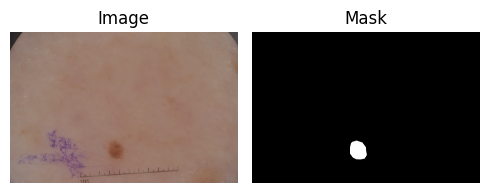

In [12]:
############################ Reference: Practical Lab 7 ############################

#random open image 
id = np.random.randint(len(images_filenames))
img  = Image.open(os.path.join(images_dir, images_filenames[id] + ".jpg"))
mask = Image.open(os.path.join(masks_dir, images_filenames[id] + "_segmentation.png"))
mask = preprocess_mask(mask)
show_sample(img, mask)


In [13]:
############################ Practical Lab 7 ############################

#data augementation for training images and mask

train_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize(size=(256, 256), interpolation=InterpolationMode.BILINEAR, antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.RandomRotation(degrees=30),
        v2.ColorJitter(brightness=.3, contrast = 0.3),
        v2.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        v2.ToDtype(torch.float32, scale=True), # convert to float32 and scale to [0, 1]
        v2.Normalize(mean=MEAN, std=STD)
    ])
train_transform

Compose(
      ToImage()
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.5)
      RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
      ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3))
      GaussianBlur(kernel_size=(5, 5), sigma=[0.1, 2.0])
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

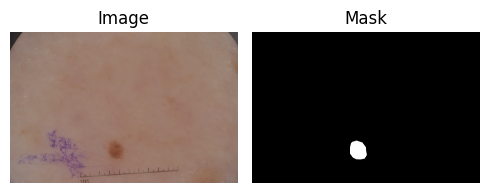

In [14]:
############################ Reference: Practical Lab 7 ############################

#use to transform image and mask
img  = Image.open(os.path.join(images_dir, images_filenames[id] + ".jpg"))
mask = Image.open(os.path.join(masks_dir, images_filenames[id] + "_segmentation.png"))
mask = preprocess_mask(mask)
show_sample(img, mask)

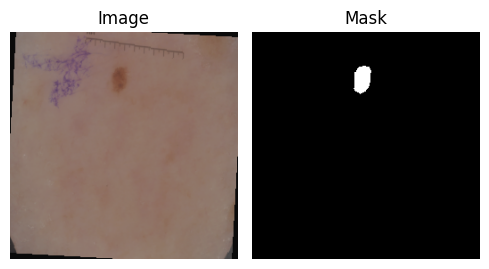

In [15]:
############################ Reference: Practical Lab 7 ############################

#transforming both image and mask together ## this contain color jitter
transformed_img, transformed_mask = train_transform(img, mask)
show_sample(transformed_img, transformed_mask, unnormalize=True)

In [16]:
############################ Reference: Practical Lab 7 ############################

#data augementation for validation images and mask

val_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=MEAN, std=STD)
    ])

In [17]:
############################ Reference: Practical Lab 7 ############################

#data augementation for validation images and mask

test_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=MEAN, std=STD)
    ])

In [18]:
############################ Reference: Practical Lab 7 ############################

# A class for storing dataset
# During training will return mask, during testing no mask only resolution
class Cancer(Dataset):
    def __init__(self, images_filenames, images_dir, masks_dir, transform=None, test_mode=False):

        self.images_filenames = images_filenames
        self.images_dir       = images_dir
        self.masks_dir        = masks_dir
        self.transform = transform
        self.test_mode = test_mode

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):

        # get image at position idx
        image = Image.open(os.path.join(images_dir, self.images_filenames[idx]+ ".jpg"))
        image = tv_tensors.Image(image) 


        #during training return mask, testing dont assume a mask(only get back resolution)
        # for test mode, return the image and its actual resolution
        if self.test_mode:
            resolution = image.shape[1:] #(C,H,W)
        #    if the transformation pipeline is passed by user
            if self.transform is not None:
                image = self.transform(image)
                
            mask = Image.open(os.path.join(self.masks_dir, self.images_filenames[idx] + "_segmentation.png"))
            mask = preprocess_mask(mask)
            if self.transform is not None:
                _, mask = self.transform(None, mask)  # Apply transformation to mask (assuming it doesn't need any transformation)
            return image, resolution, mask

        # for train mode, return the image and its mask
        mask = Image.open(os.path.join(masks_dir, self.images_filenames[idx] + "_segmentation.png"))
        mask = preprocess_mask(mask)
        # if the transformation pipeline is passed by user
        if self.transform is not None:
            image, mask = self.transform(image, mask)
            
        return image, mask


In [19]:
############################ Reference: Practical Lab 7 ############################

#pass trainset to training loader
trainset    = Cancer(train_images_filenames, images_dir, masks_dir, transform=train_transform, test_mode=False)
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True, num_workers=2)

x_batch, y_batch = next(iter(trainloader))
print(f'{x_batch.shape = }')
print(f'{y_batch.shape = }')

x_batch.shape = torch.Size([12, 3, 256, 256])
y_batch.shape = torch.Size([12, 1, 256, 256])


In [20]:
############################ Reference: Practical Lab 7 ############################

#pass trainset to validation loader
valset      = Cancer(val_images_filenames, images_dir, masks_dir, transform=val_transform, test_mode=False)
valloader   = DataLoader(valset, batch_size = BATCH_SIZE, shuffle=False, num_workers=2)

x_batch, y_batch = next(iter(valloader))
print(f'{x_batch.shape = }')
print(f'{y_batch.shape = }')

x_batch.shape = torch.Size([12, 3, 256, 256])
y_batch.shape = torch.Size([12, 1, 256, 256])


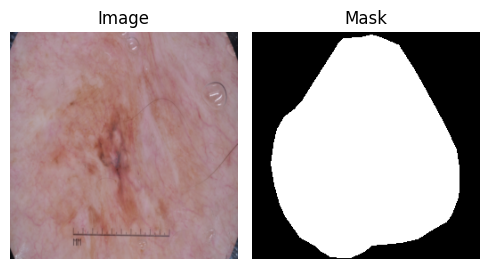

Resolution of image torch.Size([2848, 4288])


In [21]:
############################ Reference: Practical Lab 7 ############################

#pass trainset to testing loader
testset     = Cancer(test_images_filenames, images_dir, masks_dir, transform=test_transform, test_mode=True)
testloader   = DataLoader(testset, batch_size = BATCH_SIZE, shuffle=False, num_workers=2)
img, res, mask    = testset[np.random.randint(len(testset))]
show_sample(img, mask, unnormalize=True)
print('Resolution of image', res)

In [32]:
#This will be used to save the model, so that we can choose either one model for our final segmentation architecture
model_List = [] 

# Model Training

# UNET 

In [22]:
############################ Reference: Practical 7 ############################

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3,1,1)
        self.bn1   = nn.BatchNorm2d(out_channels) #help training and normalize data, less overfitting, generaze better

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3,1,1)
        self.bn2   = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
            
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        return x

In [23]:
############################ Reference: Practical 7 ############################

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512,1024]):
        super().__init__()

        # encoder layers (double conv)
        self.enc_dblconv_layers = nn.ModuleList()
        in_c = in_channels
        for out_c in features:
            self.enc_dblconv_layers.append(DoubleConv(in_c,out_c))
            in_c = out_c
        
        
        # bottleneck layer between encoder and encoder #last doubleDC
        self.enc_lastdbconv = DoubleConv(features[-1], features[-1]*2)

        # decoder layers (double conv)
        self.dec_dblconv_layers =nn.ModuleList()
        for out_c in reversed(features):
            self.dec_dblconv_layers.append(DoubleConv(out_c*2,out_c))

        # decoder part (upsampling)
        self.dec_transconv_layers = nn.ModuleList()
        for out_c in reversed(features):
            self.dec_transconv_layers.append(nn.ConvTranspose2d(out_c*2,out_c, kernel_size=2, stride=2))

        # classification block
        self.classifier = nn.Conv2d(in_channels = features[0], out_channels = out_channels, kernel_size=1)

    def forward(self, x):
        enc_activations = [] # LIFO to store the encoder outputs
        # ---------------------------------------
        # forward prop through the encoder block
        # ---------------------------------------
        # for each encoder layer:
        for enc_dbconv in self.enc_dblconv_layers:

            # forward propagate through the double convolutional block
            x= enc_dbconv(x)
            
            # insert into enc_activations
            enc_activations.insert(0,x) #LIPO - save here

            # Max pool to reduce the resolution
            x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)

        # go through the bottleneck layer
        x = self.enc_lastdbconv(x)

        # ---------------------------------------
        # forward prop through the decoder block
        # ---------------------------------------
        for enc_activation, dec_transconv, dec_dconv in zip(enc_activations, self.dec_transconv_layers, self.dec_dblconv_layers): #store high resolution in the encoder, upsampling,
            # perform transpose convolution
            x = dec_transconv(x)
            # interpolate enc_activation to the resolution of x (resize) # (B, Cd, Hd, Wd) => #(B,Ce,He, Wd)
            enc_activation = F.interpolate(enc_activation, x.shape[2:], mode = "bilinear", align_corners =True) #(enc_activation: (He, We) ----> Hd, Wd)

            # concatenate enc_activation and x along the channel dimension
            x = torch.cat((enc_activation,x), dim =1) #shape of output x = (B, Ce+Cd, Hd, We)

            # double convolutional block
            x = dec_dconv(x)
            
        # sigmoid activation (single class segmentation)
        x = self.classifier(x)
        x = torch.sigmoid(x)
            
        return x

In [24]:
summary(UNET(), input_size=(4, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNET                                     [4, 1, 256, 256]          --
├─ModuleList: 1-1                        --                        --
│    └─DoubleConv: 2-1                   [4, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [4, 64, 256, 256]         1,792
│    │    └─BatchNorm2d: 3-2             [4, 64, 256, 256]         128
│    │    └─Conv2d: 3-3                  [4, 64, 256, 256]         36,928
│    │    └─BatchNorm2d: 3-4             [4, 64, 256, 256]         128
│    └─DoubleConv: 2-2                   [4, 128, 128, 128]        --
│    │    └─Conv2d: 3-5                  [4, 128, 128, 128]        73,856
│    │    └─BatchNorm2d: 3-6             [4, 128, 128, 128]        256
│    │    └─Conv2d: 3-7                  [4, 128, 128, 128]        147,584
│    │    └─BatchNorm2d: 3-8             [4, 128, 128, 128]        256
│    └─DoubleConv: 2-3                   [4, 256, 64, 64]        

In [25]:
############################ Reference: Practical 7 ############################

# This class will help us store the loss and dice score, so we can see both values changing when training

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"]   += val
        metric["count"] += 1
        metric["avg"]   = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [26]:
############################ Adapted from Practical 7 ############################

# Specify how the training goes in one epoch time

def train_one_epoch(model, data_loader, criterion, optimizer, epoch, device):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(data_loader)
    for images, target in stream:
        images = images.to(device)
        target = target.float().to(device)

        #As the outputs of both model are diff, we need to explicitly extract the output
        modelName = (type(model).__name__)
        if(modelName == "UNET"):
            yhat = model(images)
        elif(modelName == "DeepLabV3"):
            yhat = model(images)['out']

        #Compute the cost    
        cost = criterion(yhat, target)
        #Update the cost
        metric_monitor.update("Cost", cost.item())
        
        
        ypred = (yhat >= 0.5).float()
        #Compute the Dice Score
        dice = dice_score(ypred, target)
        #Update the Dice Score
        metric_monitor.update("Dice", dice.item())
        

        #Clear the gradients for not stacking in each run
        optimizer.zero_grad()
        #Backpropagation
        cost.backward()
        #Update the gradients
        optimizer.step()

        stream.set_description("Epoch: {epoch:2d} | Train mode      | {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))

    return metric_monitor


In [27]:
############################ Reference: Practical 7 ############################

#The formula of dice score
def dice_score(ypred, y):
    return 2 * (ypred * y).sum() / ((ypred + y).sum() + 1e-8)

In [28]:
############################ Adapted from Practical 7 ############################

# Specify how the validation goes in one epoch time
def validate(model, dataloader, criterion, metric, epoch, device):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(dataloader)
    with torch.no_grad():
        for i, (x, y) in enumerate(stream, start=1):
            x = x.to(device)
            y = y.float().to(device)

            modelName = (type(model).__name__)
            if(modelName == "UNET"):
                yhat = model(x)
            elif(modelName == "DeepLabV3"):
                yhat = model(x)['out']
            
            cost = criterion(yhat, y)

            ypred = (yhat >= 0.5).float()
            dice = dice_score(ypred, y)
            
            metric_monitor.update("Cost", cost.item())
            metric_monitor.update("Dice", dice.item())
            stream.set_description("Epoch: {epoch:2d} | Train mode      | {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
            stream.set_description("          | Validation mode | {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    
    return metric_monitor

In [29]:
############################ Reference: Practical 7 ############################

#Save the trained model
def save_model (checkpoint_file, model, optimizer, epoch):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_file)

In [30]:
############################ Adapted from Practical 7 ############################

from torch.optim.lr_scheduler import StepLR 

# Adjust LR every 5 epochs by multiplying by 0.1
train_metrics = {}
val_metrics = {}

#start training the model
def train_and_validate(model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs, device):
    model_Name = type(model).__name__
    train_metrics[model_Name] = []
    val_metrics[model_Name] = []
    for epoch in range(1, num_epochs + 1):
        train_metric_monitor = train_one_epoch(model, trainloader, criterion, optimizer, epoch, device)
        train_metrics[model_Name].append(train_metric_monitor)
        val_metric_monitor = validate(model, valloader, criterion, dice_score, epoch, device)
        val_metrics[model_Name].append(val_metric_monitor)
        
        scheduler.step()  # Step the scheduler after each epoch
    
    save_model(f"{model_Name}_Seg_Model.pth", model, optimizer, epoch)



# Train UNET Model

In [33]:
############################ Adapted from Practical 7 ############################

model = UNET().to(DEVICE)

#insert the model to available model list
model_List.append(model)


optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCELoss().to(DEVICE)
# Define the scheduler
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) 

cuda:0


In [ ]:
############################ ############################ Reference: Practical 7 ############################ ############################

#Cost, Dice Score for Unet when training in each epoch time
train_and_validate(model, trainloader, valloader, criterion, optimizer, scheduler, NUM_EPOCHS, DEVICE)

Epoch:  1 | Train mode      | Cost: 0.290 | Dice: 0.707: 100%|██████████| 130/130 [03:10<00:00,  1.46s/it]
          | Validation mode | Cost: 0.358 | Dice: 0.684: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it]
Epoch:  2 | Train mode      | Cost: 0.258 | Dice: 0.736: 100%|██████████| 130/130 [03:14<00:00,  1.50s/it]
          | Validation mode | Cost: 0.263 | Dice: 0.746: 100%|██████████| 44/44 [00:56<00:00,  1.29s/it]
Epoch:  3 | Train mode      | Cost: 0.238 | Dice: 0.758: 100%|██████████| 130/130 [03:15<00:00,  1.50s/it]
          | Validation mode | Cost: 0.236 | Dice: 0.787: 100%|██████████| 44/44 [00:57<00:00,  1.31s/it]
Epoch:  4 | Train mode      | Cost: 0.225 | Dice: 0.776: 100%|██████████| 130/130 [03:09<00:00,  1.46s/it]
          | Validation mode | Cost: 0.237 | Dice: 0.789: 100%|██████████| 44/44 [00:56<00:00,  1.30s/it]
Epoch:  5 | Train mode      | Cost: 0.224 | Dice: 0.773: 100%|██████████| 130/130 [03:18<00:00,  1.52s/it]
          | Validation mode | Cost: 0.248 | D

# DeepLabV3 (Pretrained Model)
############################ Coded by All ############################

In [33]:
#Load the DeepLabV3 with RestNet-101 backbone
DeepLab101 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 161MB/s]  


In [34]:
model = DeepLab101

In [35]:
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [36]:
#In order to give one output feature whether it is 0 or 1

classification_layer = nn.Sequential(
nn.Conv2d(in_channels=256, out_channels = 1, kernel_size=1, stride=1),
nn.Sigmoid())

model.aux_classifier[4] = classification_layer
model.classifier[4] = classification_layer

In [37]:
#Check the replacement
summary(model, (4,3,256, 256))

Layer (type:depth-idx)                             Output Shape              Param #
DeepLabV3                                          [4, 1, 256, 256]          --
├─IntermediateLayerGetter: 1-1                     [4, 2048, 32, 32]         --
│    └─Conv2d: 2-1                                 [4, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                            [4, 64, 128, 128]         128
│    └─ReLU: 2-3                                   [4, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                              [4, 64, 64, 64]           --
│    └─Sequential: 2-5                             [4, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                        [4, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                        [4, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                        [4, 256, 64, 64]          70,400
│    └─Sequential: 2-6                             [4, 512, 32, 32]          --
│    │    └─Bottlen

In [38]:
#Check all the parameters which requires gradient computation, if Yes, it will be replaced when training
for name, param in model.named_parameters():
    print(name, "--->", param.requires_grad) 

backbone.conv1.weight ---> True
backbone.bn1.weight ---> True
backbone.bn1.bias ---> True
backbone.layer1.0.conv1.weight ---> True
backbone.layer1.0.bn1.weight ---> True
backbone.layer1.0.bn1.bias ---> True
backbone.layer1.0.conv2.weight ---> True
backbone.layer1.0.bn2.weight ---> True
backbone.layer1.0.bn2.bias ---> True
backbone.layer1.0.conv3.weight ---> True
backbone.layer1.0.bn3.weight ---> True
backbone.layer1.0.bn3.bias ---> True
backbone.layer1.0.downsample.0.weight ---> True
backbone.layer1.0.downsample.1.weight ---> True
backbone.layer1.0.downsample.1.bias ---> True
backbone.layer1.1.conv1.weight ---> True
backbone.layer1.1.bn1.weight ---> True
backbone.layer1.1.bn1.bias ---> True
backbone.layer1.1.conv2.weight ---> True
backbone.layer1.1.bn2.weight ---> True
backbone.layer1.1.bn2.bias ---> True
backbone.layer1.1.conv3.weight ---> True
backbone.layer1.1.bn3.weight ---> True
backbone.layer1.1.bn3.bias ---> True
backbone.layer1.2.conv1.weight ---> True
backbone.layer1.2.bn1.wei

In [39]:
#Only train the classification layer, as we use the feature extractor method
for name, param in model.named_parameters():
    if name.find("classifier") == -1:
        param.requires_grad = False
    print(name, "--->", param.requires_grad) 
    

backbone.conv1.weight ---> False
backbone.bn1.weight ---> False
backbone.bn1.bias ---> False
backbone.layer1.0.conv1.weight ---> False
backbone.layer1.0.bn1.weight ---> False
backbone.layer1.0.bn1.bias ---> False
backbone.layer1.0.conv2.weight ---> False
backbone.layer1.0.bn2.weight ---> False
backbone.layer1.0.bn2.bias ---> False
backbone.layer1.0.conv3.weight ---> False
backbone.layer1.0.bn3.weight ---> False
backbone.layer1.0.bn3.bias ---> False
backbone.layer1.0.downsample.0.weight ---> False
backbone.layer1.0.downsample.1.weight ---> False
backbone.layer1.0.downsample.1.bias ---> False
backbone.layer1.1.conv1.weight ---> False
backbone.layer1.1.bn1.weight ---> False
backbone.layer1.1.bn1.bias ---> False
backbone.layer1.1.conv2.weight ---> False
backbone.layer1.1.bn2.weight ---> False
backbone.layer1.1.bn2.bias ---> False
backbone.layer1.1.conv3.weight ---> False
backbone.layer1.1.bn3.weight ---> False
backbone.layer1.1.bn3.bias ---> False
backbone.layer1.2.conv1.weight ---> False


In [40]:
#DeepLabV3
model = model.to(DEVICE)
model_List.append(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCELoss().to(DEVICE)
# Define the scheduler
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) 

In [41]:
#Retrain the Pretrained model(DeepLabV3)
train_and_validate(model, trainloader, valloader, criterion, optimizer, scheduler, NUM_EPOCHS, DEVICE)

Epoch:  1 | Train mode      | Cost: 0.220 | Dice: 0.796: 100%|██████████| 130/130 [02:51<00:00,  1.32s/it]
          | Validation mode | Cost: 0.199 | Dice: 0.809: 100%|██████████| 44/44 [00:52<00:00,  1.20s/it]
Epoch:  2 | Train mode      | Cost: 0.173 | Dice: 0.828: 100%|██████████| 130/130 [02:45<00:00,  1.27s/it]
          | Validation mode | Cost: 0.159 | Dice: 0.849: 100%|██████████| 44/44 [00:53<00:00,  1.23s/it]
Epoch:  3 | Train mode      | Cost: 0.163 | Dice: 0.836: 100%|██████████| 130/130 [02:51<00:00,  1.32s/it]
          | Validation mode | Cost: 0.154 | Dice: 0.855: 100%|██████████| 44/44 [00:52<00:00,  1.18s/it]
Epoch:  4 | Train mode      | Cost: 0.154 | Dice: 0.847: 100%|██████████| 130/130 [02:47<00:00,  1.29s/it]
          | Validation mode | Cost: 0.174 | Dice: 0.819: 100%|██████████| 44/44 [00:52<00:00,  1.20s/it]
Epoch:  5 | Train mode      | Cost: 0.152 | Dice: 0.847: 100%|██████████| 130/130 [02:53<00:00,  1.33s/it]
          | Validation mode | Cost: 0.145 | D

# Model Evaluation

# Show Training and Validation Loss Graph

############################ Coded by All ############################

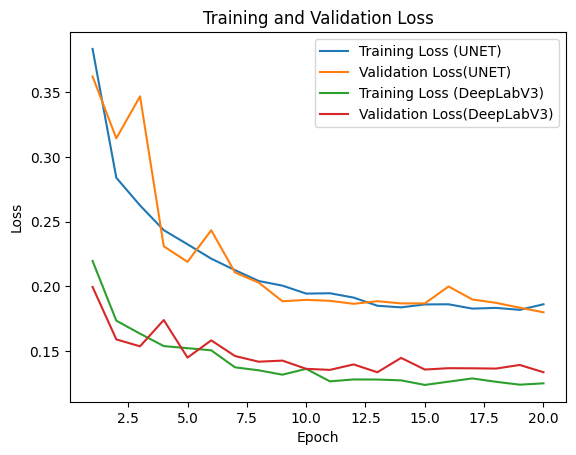

In [42]:
train_loss = {}
val_loss = {}

for model_Name in train_metrics:
    
    #initialise dict
    train_loss[model_Name] = []
    val_loss[model_Name] = []
    
    for metrics in train_metrics[model_Name]:
        train_loss[model_Name].append(metrics.metrics["Cost"]["avg"])
        
        
    for metrics in val_metrics[model_Name]:
        val_loss[model_Name].append(metrics.metrics["Cost"]["avg"])
    
    epochs = range(1, len(train_loss[model_Name]) + 1)
    plt.plot(epochs, train_loss[model_Name], label=f'Training Loss ({model_Name})')
    plt.plot(epochs, val_loss[model_Name], label=f'Validation Loss({model_Name})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
    

# Show Training and Validation Dice Score
############################ Coded by All ############################

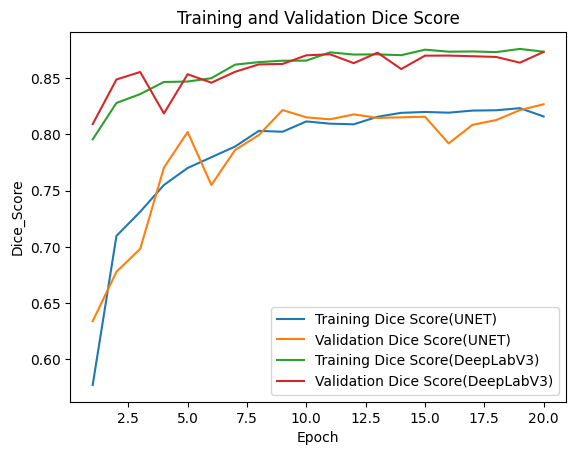

In [43]:
train_dice = {}
val_dice = {}

for model_Name in train_metrics:
    
    #initialise dict
    train_dice[model_Name] = []
    val_dice[model_Name] = []
    
    
    for metrics in train_metrics[model_Name]:
        train_dice[model_Name].append(metrics.metrics["Dice"]["avg"])
        
    for metrics in val_metrics[model_Name]:
        val_dice[model_Name].append(metrics.metrics["Dice"]["avg"])
    
    epochs = range(1, len(train_loss[model_Name]) + 1)
    plt.plot(epochs, train_dice[model_Name], label=f'Training Dice Score({model_Name})')
    plt.plot(epochs, val_dice[model_Name], label=f'Validation Dice Score({model_Name})')

plt.xlabel('Epoch')
plt.ylabel('Dice_Score')
plt.title('Training and Validation Dice Score')
plt.legend()
plt.show()

# Evaluate on the test set
############################ Code by All ############################

In [27]:
#Predicing the testing set
def predict(model, testloader, morph=False):
    model.eval()
    modelName = (type(model).__name__)
           
    predictions = torch.tensor([])
    predictions_morph = torch.tensor([])
    stream = tqdm(testloader)
    with torch.no_grad():

        for x_batch, res_batch, _ in stream: 
            x_batch = x_batch.to(DEVICE)
            
            if(modelName == "UNET"):
                yhat_batch = model(x_batch)
            elif(modelName == "DeepLabV3"):
                yhat_batch = model(x_batch)['out']

            if morph:
                # Apply sigmoid and convert to binary mask
                ypred_batch = (yhat_batch >= 0.5).float().cpu()
                # Apply dilation and erosion
                ypred_batch_morph = morphological(ypred_batch)
            else:
                ypred_batch = (yhat_batch >= 0.5).float().cpu()
                
            predictions = torch.cat((predictions, ypred_batch), dim=0)
            predictions_morph = torch.cat((predictions_morph, ypred_batch_morph), dim=0)

    return predictions, predictions_morph

In [29]:
############################ Coded by All ############################

#Transform the output mask with erosion and dilation techniques so that it is more robust
def morphological(predictions, kernel_size=3):
    # Move predictions to CPU
    predictions_cpu = predictions.cpu().numpy()

    # Define erosion and dilation kernels
    erosion_kernel = torch.ones(1, 1, kernel_size, kernel_size)
    dilation_kernel = torch.ones(1, 1, kernel_size, kernel_size)

    # Perform dilation and erosion
    processed_predictions = torch.stack([
        F.conv2d(F.conv2d(torch.tensor(mask), weight=dilation_kernel, padding=kernel_size//2), 
                  weight=erosion_kernel, padding=kernel_size//2)
        for mask in predictions_cpu
    ])
    
    processed_predictions = (processed_predictions > 0).float()  # Ensuring binary output

    return processed_predictions

# Loading the Save Model (In case that the kernal suddenly restart after training)

In [19]:
ls "/kaggle/input/deeplabgroup8_test/pytorch/test/1/DeepLabV3_Seg_Model.pth"

/kaggle/input/deeplabgroup8_test/pytorch/test/1/DeepLabV3_Seg_Model.pth


In [20]:
############################ Coded by All ############################

# Load the saved model for Unet and DeepLabV3
save_model_Unet_checkpoint = '/kaggle/input/deeplabgroup8_test/pytorch/test/1/UNET_Seg_Model.pth'
save_model_Unet = torch.load(save_model_Unet_checkpoint)
save_model_deepLab_checkpoint = '/kaggle/input/deeplabgroup8_test/pytorch/test/1/DeepLabV3_Seg_Model.pth'
save_model_deepLab = torch.load(save_model_deepLab_checkpoint)

In [21]:
############################ Coded by All ############################

#Load the state to unet
unet = UNET().to(DEVICE)
unet.load_state_dict(save_model_Unet['model_state_dict'])


<All keys matched successfully>

In [22]:
############################ Coded by All ############################

#Load the state to deeplabv3

deeplab = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)

classification_layer = nn.Sequential(
nn.Conv2d(in_channels=256, out_channels = 1, kernel_size=1, stride=1),
nn.Sigmoid())



deeplab.aux_classifier[4] = classification_layer
deeplab.classifier[4] = classification_layer

deeplab.load_state_dict(save_model_deepLab['model_state_dict'])

deeplab = deeplab.to(DEVICE)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:13<00:00, 18.1MB/s] 


In [24]:
model_List = []
model_List.append(unet)
model_List.append(deeplab)

In [ ]:
print(model_List)

In [25]:
for idx, i in enumerate(model_List): 
    print(f'Model[{idx}]: {type(i).__name__}')

Model[0]: UNET
Model[1]: DeepLabV3


In [30]:
############################ Coded by All ############################

# Compute 2 predicted masks, one is the original mask from prediction, another one is processed with morphological operation after prediction
predictions = []
predictions_morph = []
for idx, model in enumerate(model_List):
    predictionsTemp, predictions_morphTemp = predict(model, testloader, True)
    predictions.append(predictionsTemp)
    predictions_morph.append(predictions_morphTemp)


100%|██████████| 44/44 [00:55<00:00,  1.27s/it]


In [31]:
############################ Coded by All ############################

# Compute the average Dice Score for each model using testing set
def calculate_dice_score(testset, predictions, processed_predictions):
    mean_tensor = torch.tensor(MEAN).reshape(1, -1, 1, 1)
    std_tensor  = torch.tensor(STD).reshape(1, -1, 1, 1)
    stream = tqdm(testset)
    
    testSetSize = len(testset)
    dice = 0
    
    for idx, i in enumerate(stream):
        img, resolution, ground_truth = i
        mask_pred = predictions[idx]
        mask_processed = processed_predictions[idx]
        mask_gt = ground_truth
        
        # Resize and normalize the image
        img = v2.functional.resize(img, size=resolution, antialias=True)
        mean_tensor = torch.tensor(MEAN).reshape(-1, 1, 1)
        std_tensor  = torch.tensor(STD).reshape(-1, 1, 1)
        img = img*std_tensor + mean_tensor
        img = np.transpose(img, (1, 2, 0))

        # Resize masks and remove channel dimension if present
        mask_pred = v2.functional.resize(mask_pred, size=resolution, antialias=True).squeeze()
        mask_processed = v2.functional.resize(mask_processed, size=resolution, antialias=True).squeeze()
        mask_gt = v2.functional.resize(mask_gt, size=resolution, antialias=True).squeeze()
        
        # Segment the image using the processed mask
        segmented_image = img * np.expand_dims(mask_processed, axis=-1)  # Apply mask to each channel
        
        dice += dice_score(mask_processed, mask_gt)
        #print(f"Idx:{idx}:, {dice}")
    dice = dice/testSetSize
    return dice
        

In [32]:
############################ Coded by All ############################

#Calculating Dice_Score for UNET and DeepLabV3 on testing set
dice_scores = []

for idx, i in enumerate(predictions):
    dice_scores.append(calculate_dice_score(testset, predictions[idx], predictions_morph[idx]))

100%|██████████| 524/524 [05:39<00:00,  1.54it/s]


In [33]:
############################ Coded by All ############################

for idx, i in enumerate(model_List):
    print(f"{type(i).__name__} Average Dice Score: {round(dice_scores[idx].item(), 3)}")

UNET Average Dice Score: 0.812
DeepLabV3 Average Dice Score: 0.836


# Showing the Segmentation Result by Each Model
############################ Coded by All ############################

In [68]:
def show_prediction_result(testset, predictions, processed_predictions):
    mean_tensor = torch.tensor(MEAN).reshape(1, -1, 1, 1)
    std_tensor  = torch.tensor(STD).reshape(1, -1, 1, 1)

    figure, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 5 * 2))

#     for i in range(len(testset)):
    for i in range(2):
        img, resolution, ground_truth = testset[i]
        mask_pred = predictions[i]
        mask_processed = processed_predictions[i]
        mask_gt = ground_truth

        # Resize and normalize the image
        img = v2.functional.resize(img, size=resolution, antialias=True)
        mean_tensor = torch.tensor(MEAN).reshape(-1, 1, 1)
        std_tensor  = torch.tensor(STD).reshape(-1, 1, 1)
        img = img*std_tensor + mean_tensor
        img = np.transpose(img, (1, 2, 0))

        # Resize masks and remove channel dimension if present
        mask_pred = v2.functional.resize(mask_pred, size=resolution, antialias=True).squeeze()
        mask_processed = v2.functional.resize(mask_processed, size=resolution, antialias=True).squeeze()
        mask_gt = v2.functional.resize(mask_gt, size=resolution, antialias=True).squeeze()
        
        # Segment the image using the processed mask
        segmented_image = img * np.expand_dims(mask_processed, axis=-1)  # Apply mask to each channel
        
        # Calculate IoU
        dice = dice_score(mask_processed, mask_gt)
        
        # Plotting
        ax[i, 0].imshow(img)
        ax[i, 0].set_title("Original Image")
        ax[i, 0].set_axis_off()

        ax[i, 1].imshow(mask_pred, cmap='gray')
        ax[i, 1].set_title("Predicted Mask")
        ax[i, 1].set_axis_off()

        ax[i, 2].imshow(mask_processed, cmap='gray')
        ax[i, 2].set_title("Processed Mask")
        ax[i, 2].set_axis_off()

        ax[i, 3].imshow(segmented_image)
        ax[i, 3].set_title(f"Segmented Image (Dice_Score: {dice:.4f})")
        ax[i, 3].set_axis_off()

    plt.tight_layout()
    plt.show()

# Constants

# Segmentation Task done by Unet

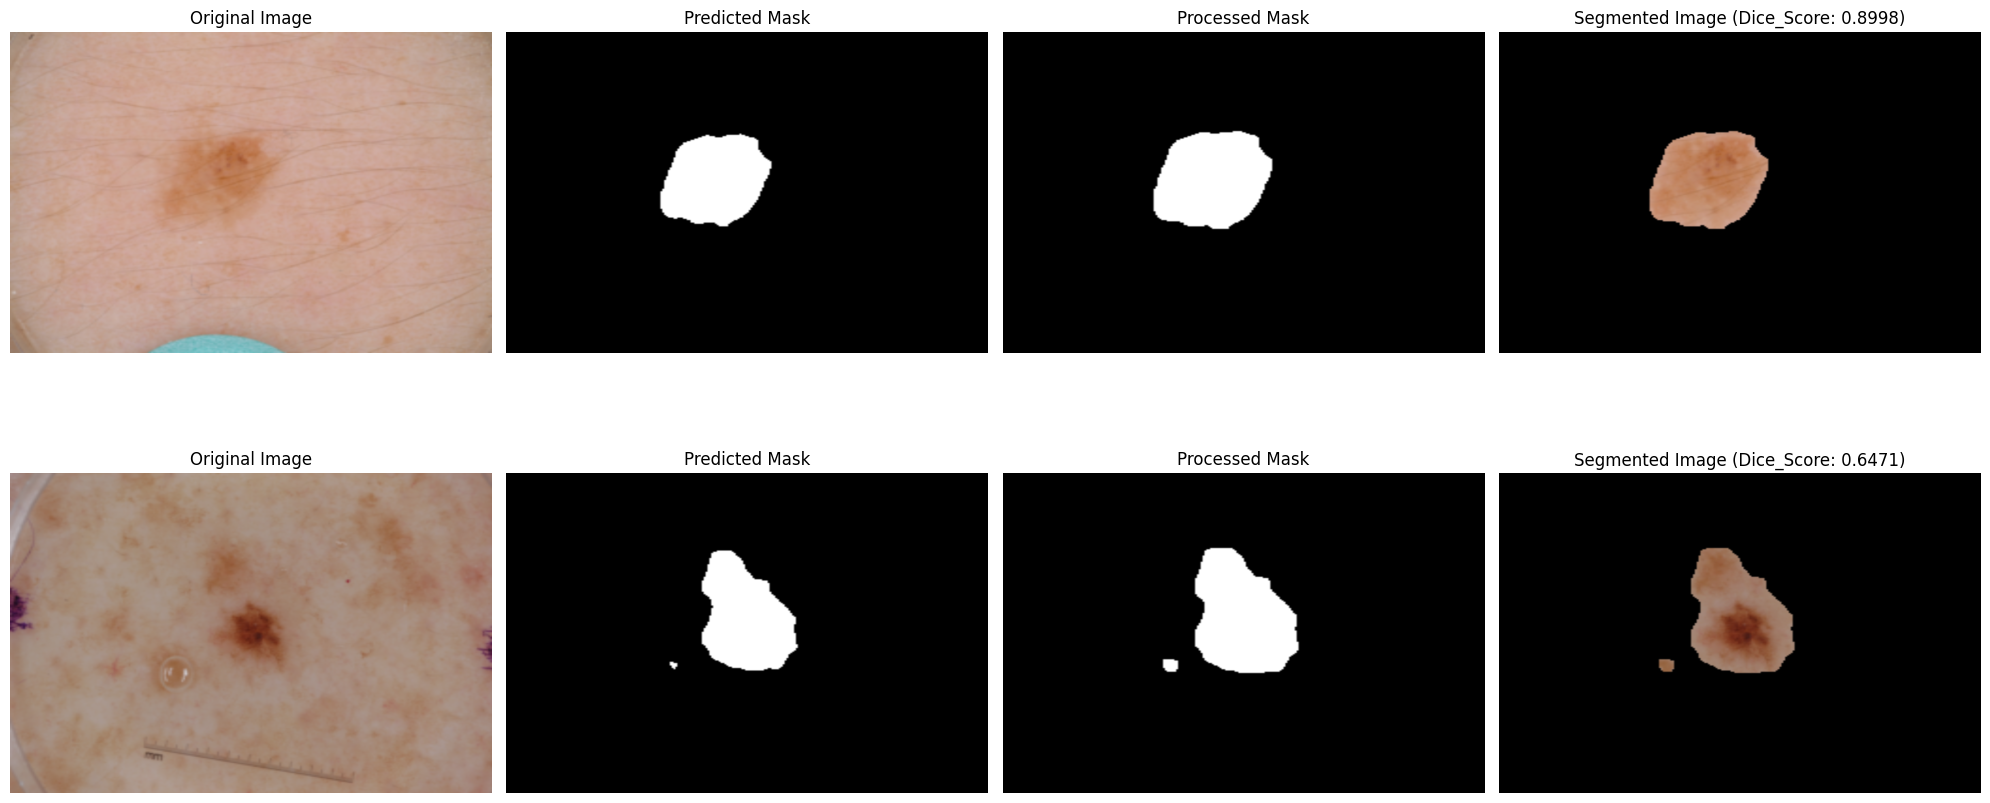

In [75]:
show_prediction_result(testset, predictions[0], predictions_morph[0])

# Segmentation Task done by DeepLabv3

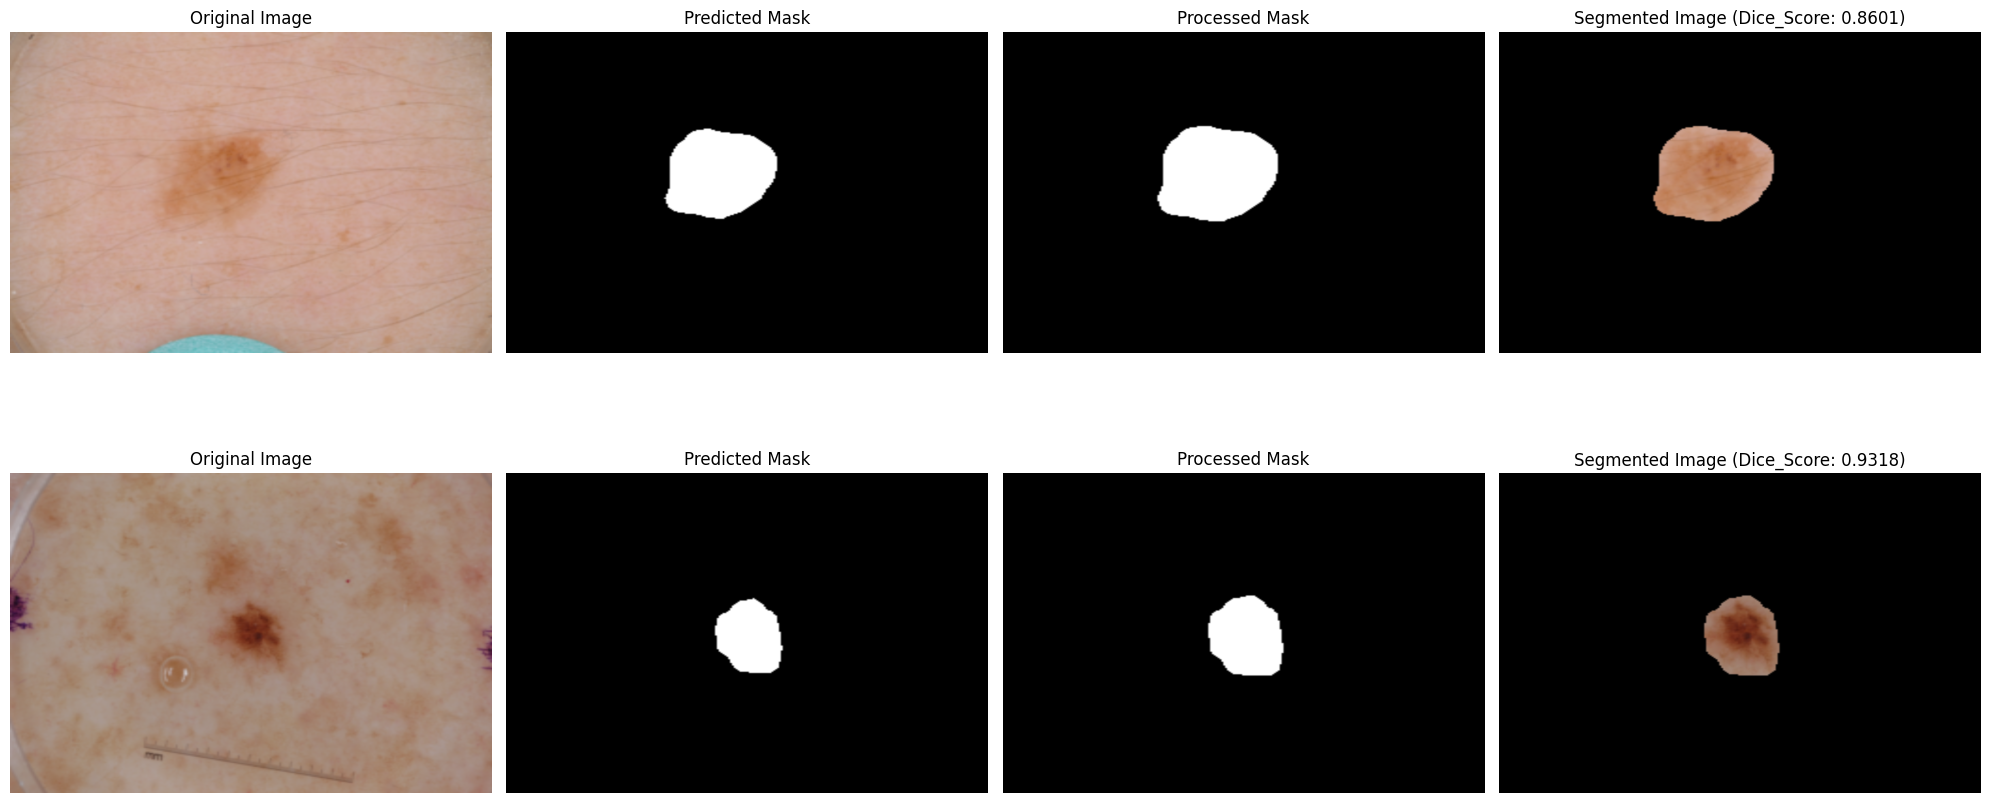

In [70]:
show_prediction_result(testset, predictions[1], predictions_morph[1])

# Inference

In [42]:
def show_one_prediction_result(testset, predictions, processed_predictions):
    mean_tensor = torch.tensor(MEAN).reshape(1, -1, 1, 1)
    std_tensor  = torch.tensor(STD).reshape(1, -1, 1, 1)

    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5 * 10))

#     for i in range(len(testset)):
    i = random.randint(0, len(testset))
    img, resolution, ground_truth = testset[i]
    mask_pred = predictions[i]
    mask_processed = processed_predictions[i]
    mask_gt = ground_truth

        # Resize and normalize the image
    img = v2.functional.resize(img, size=resolution, antialias=True)
    mean_tensor = torch.tensor(MEAN).reshape(-1, 1, 1)
    std_tensor  = torch.tensor(STD).reshape(-1, 1, 1)
    img = img*std_tensor + mean_tensor
    img = np.transpose(img, (1, 2, 0))

        # Resize masks and remove channel dimension if present
    mask_pred = v2.functional.resize(mask_pred, size=resolution, antialias=True).squeeze()
    mask_processed = v2.functional.resize(mask_processed, size=resolution, antialias=True).squeeze()
    mask_gt = v2.functional.resize(mask_gt, size=resolution, antialias=True).squeeze()
        
        # Segment the image using the processed mask
    segmented_image = img * np.expand_dims(mask_processed, axis=-1)  # Apply mask to each channel
        
        # Calculate IoU

        
        # Plotting
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].set_axis_off()

    ax[1].imshow(segmented_image)
    ax[1].set_title("Segmented Image")
    ax[1].set_axis_off()

    plt.show()

# Constants

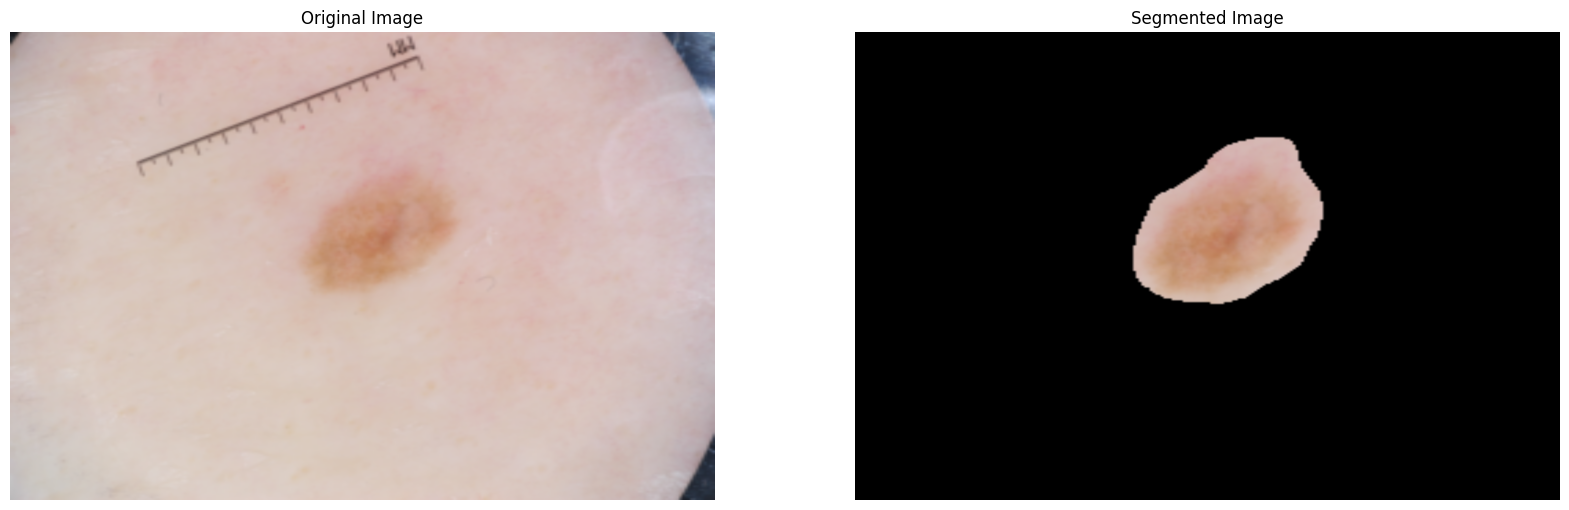

In [78]:
show_one_prediction_result(testset, predictions[1], predictions_morph[1])